In [1]:
# model -> CatBoostRegressor
# split -> TimeSeriesSplit

In [2]:
import pandas as pd

data_path = './data/processed/mart.csv'
df_for_model = pd.read_csv(data_path)
df = df_for_model.dropna()

In [3]:
# Создаем лаговые признаки
target = 'raw_mix.lab.measure.sito_009'

for lag in [1, 2, 3, 7, 14]:
    df[f'lag_{lag}'] = df[target].shift(lag)

In [4]:
from sklearn.model_selection import TimeSeriesSplit

df = df.drop(columns=['Unnamed: 0'])
df = df.dropna()

features = df.columns[df.columns != target]
X = df[features]
y = df[target]

tscv = TimeSeriesSplit(n_splits=5)

In [5]:
# Скалирование
from sklearn.preprocessing import RobustScaler

split_idx = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [6]:
# Параметры CatBoost
from catboost import CatBoostRegressor

params = {'iterations': 2000,
          'learning_rate': 0.02,
          'depth': 8,
          'loss_function': 'MAE',
          'eval_metric': 'MAE',
          'random_seed': 42,
          'od_type': 'Iter',
          'od_wait': 100,
          'l2_leaf_reg': 5,
          'grow_policy': 'Lossguide',
          'verbose': 0,
          'bootstrap_type': 'Bayesian',
          'score_function': 'L2'}
model = CatBoostRegressor(**params)

In [7]:
# Кросс-валидация
from catboost import Pool
from sklearn.metrics import mean_absolute_error
import numpy as np

fold_scores = []
for train_idx, val_idx in tscv.split(X_train_scaled):
    # Разделение данных
    X_train_fold, X_val_fold = X_train_scaled[train_idx], X_train_scaled[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

    # Создание Pool объектов для CatBoost
    train_pool = Pool(X_train_fold, y_train_fold)
    test_pool = Pool(X_val_fold, y_val_fold)

    # Обучение модели
    model.fit(train_pool, eval_set=test_pool, use_best_model=True)

    # Предсказание и оценка
    y_pred = model.predict(X_val_fold)
    mae = mean_absolute_error(y_val_fold, y_pred)
    fold_scores.append(mae)

# Средняя оценка по всем фолдам
print(f'Mean MAE across folds: {np.mean(fold_scores):.4f}')

Mean MAE across folds: 1.2188


In [8]:
# Финальное обучение
model.fit(X_train_scaled, y_train, eval_set=(X_test_scaled, y_test), use_best_model=True)

y_pred = model.predict(X_test_scaled)

In [9]:
# Оценка модели
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mae_baseline = mean_absolute_error(y_test, np.full_like(y_test, y_test.mean()))
mae_baseline_shift = mean_absolute_error(y_test[:-1], y_test[1:])

# Вычисление разностей для реальных и предсказанных значений
y_test_diff = y_test[1:].values - y_test[:-1].values
y_pred_diff = y_pred[1:] - y_pred[:-1]

# Подсчет доли сонаправленных изменений
same_direction = np.sum((y_test_diff * y_pred_diff) > 0) / len(y_test_diff)

print(f'Доля сонаправленных изменений: {same_direction:.3f}')
print(f'Mean Absolute Error Baseline: {mae_baseline}')
print(f'Mean Absolute Error Baseline shifted: {mae_baseline_shift}')
print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')

Доля сонаправленных изменений: 0.375
Mean Absolute Error Baseline: 0.9796462585034013
Mean Absolute Error Baseline shifted: 1.1999999999999997
Mean Absolute Error: 0.9625831202548031
Mean Squared Error: 1.5465090440896538


In [10]:
from datetime import datetime

# Формируем словарь с результатами
results = {
    'features': list(features),
    'metrics': {
        'mae': float(mae),
        'mae_baseline': float(mae_baseline),
        'mae_baseline_shift': float(mae_baseline_shift),
        'same_direction_ratio': float(same_direction),
        'mse': float(mse)
    },
    'timestamp': datetime.now().strftime('%Y%m%d_%H%M%S')
}

In [11]:
import json

filename = f'./results/metrics/result_CatBoost_TimeSeries.json'
with open(filename, 'w', encoding='utf-8') as f:
    json.dump(results, f, ensure_ascii=False, indent=4)

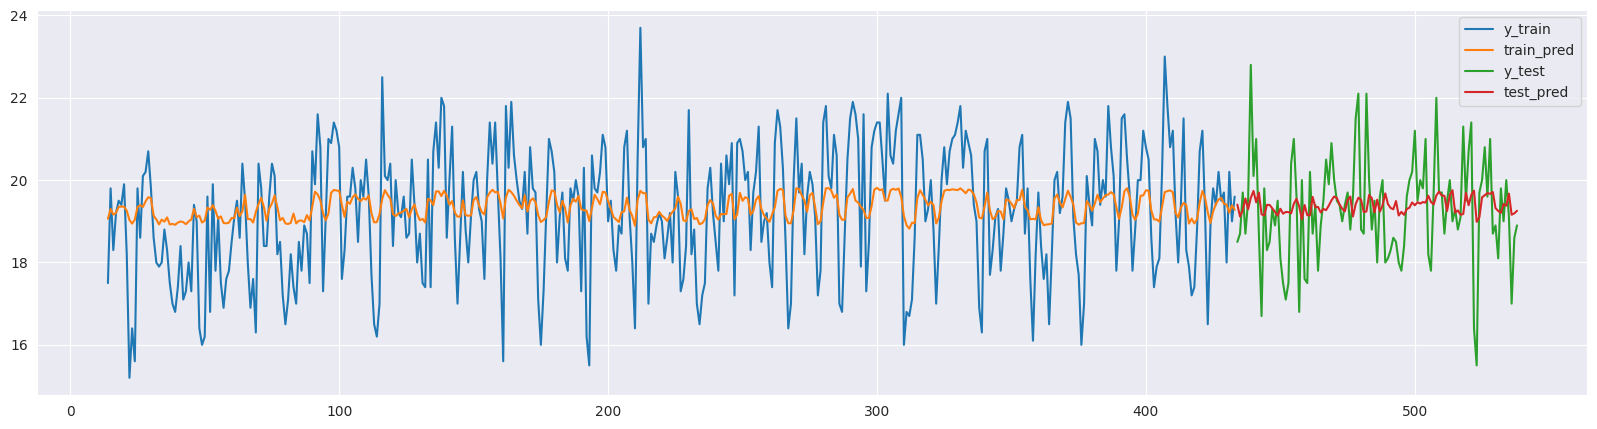

In [12]:
# Визуализация результатов
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(20, 5))
y_train.plot(ax=ax, label='y_train')
pd.DataFrame(model.predict(X_train_scaled), index=y_train.index, columns=['train_pred']).plot(ax=ax)
y_test.plot(ax=ax, label='y_test')
pd.DataFrame(y_pred, index=y_test.index, columns=['test_pred']).plot(ax=ax)
ax.legend()
plt.show()

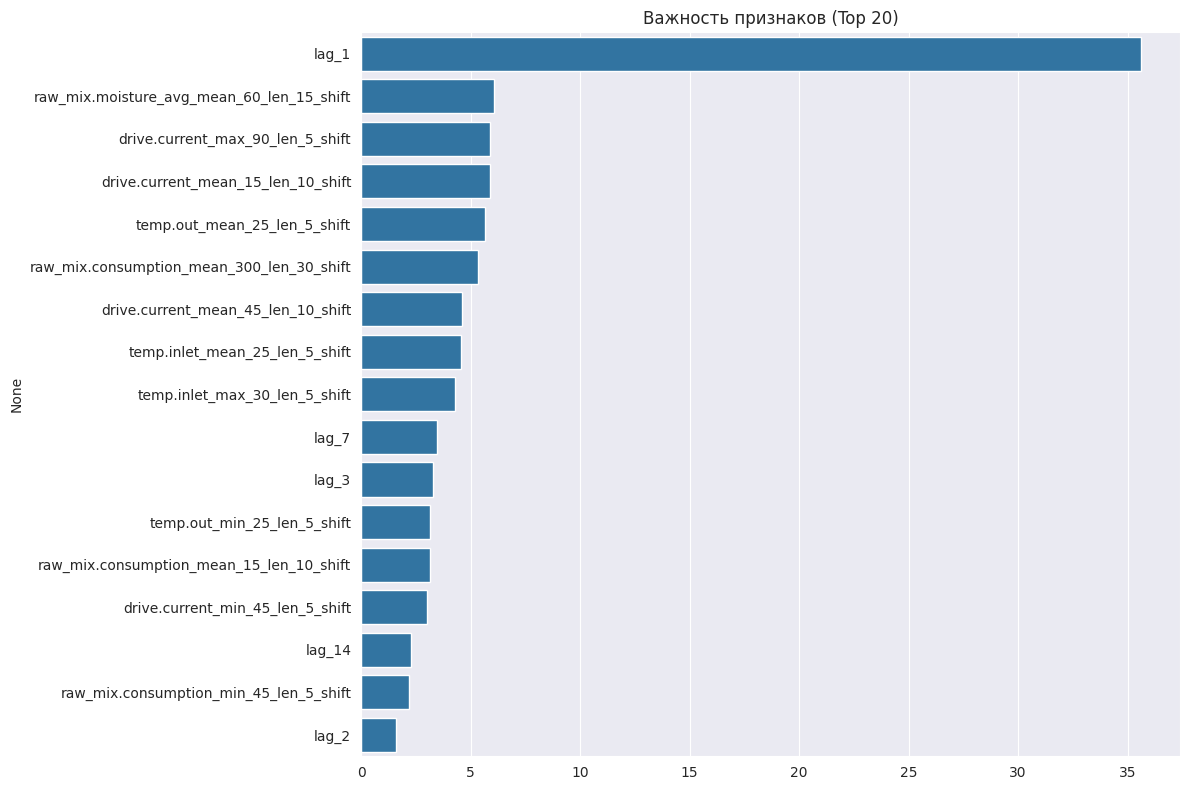

In [13]:
# Визуализация важности признаков
import seaborn as sns

feature_imp = pd.Series(model.feature_importances_, index=features).sort_values(ascending=False)[:20]
fig = plt.figure(figsize=(12, 8))
sns.barplot(x=feature_imp.values, y=feature_imp.index)
plt.title('Важность признаков (Top 20)')
plt.tight_layout()
plt.show()

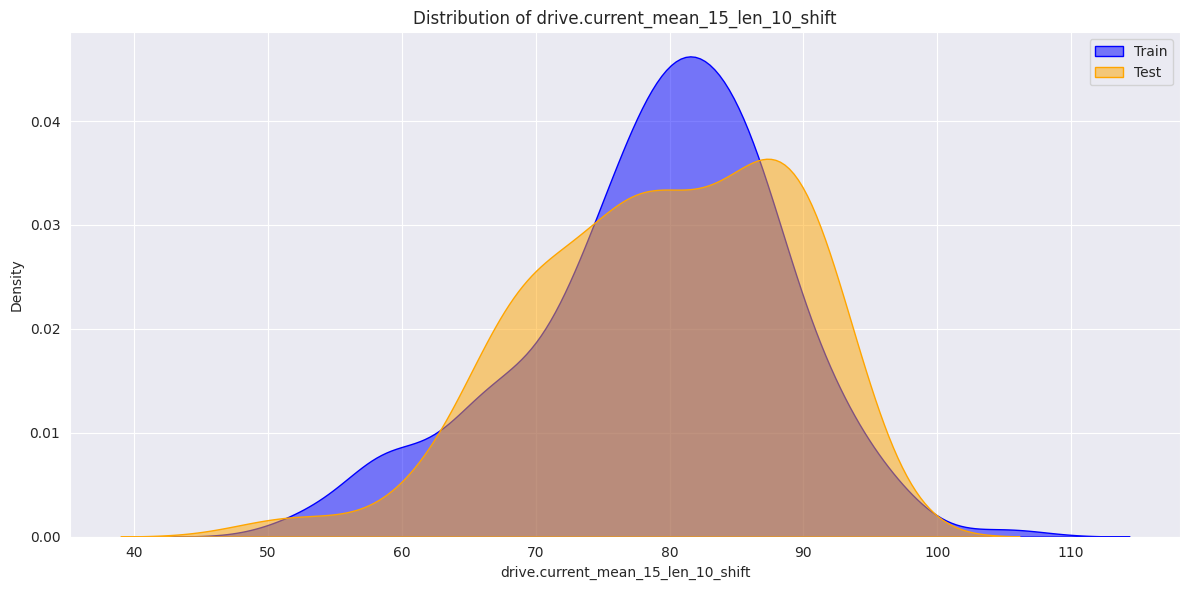

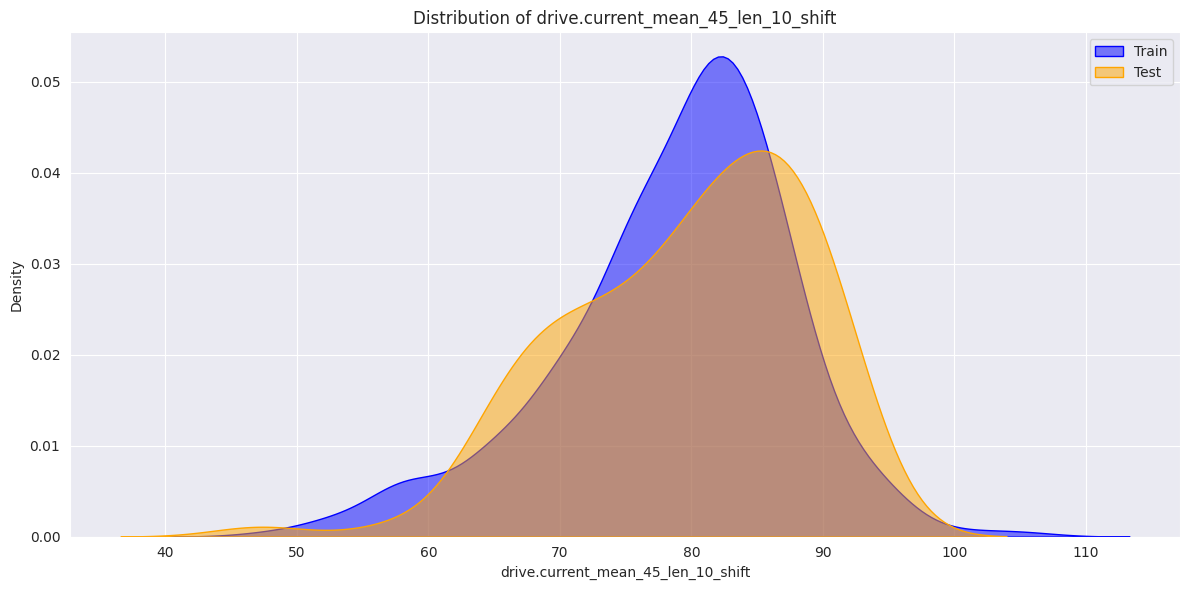

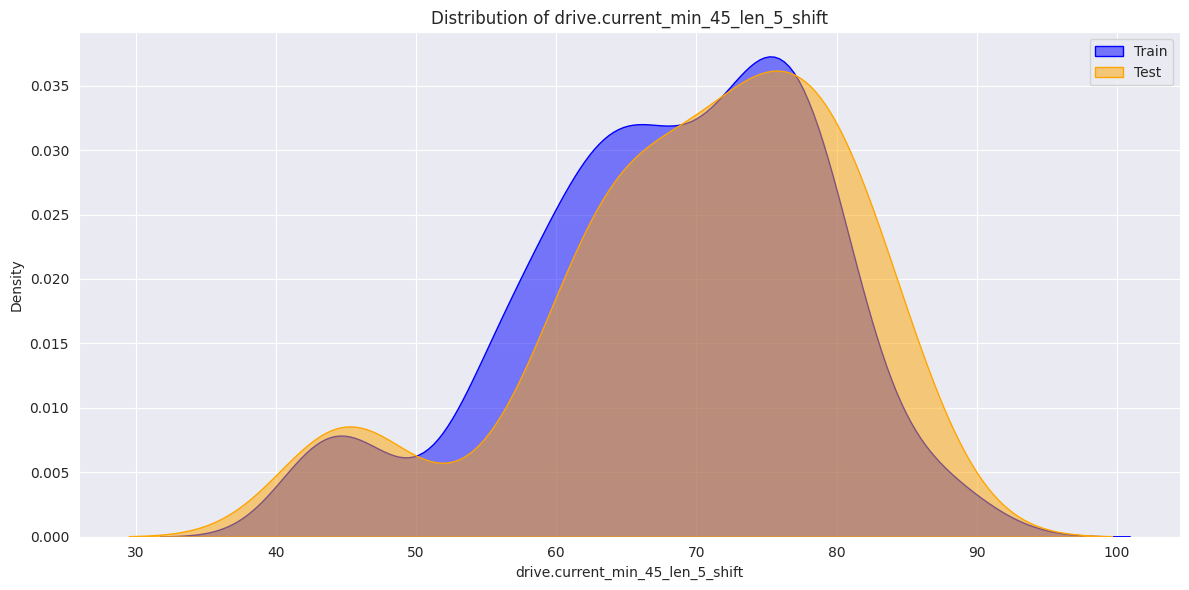

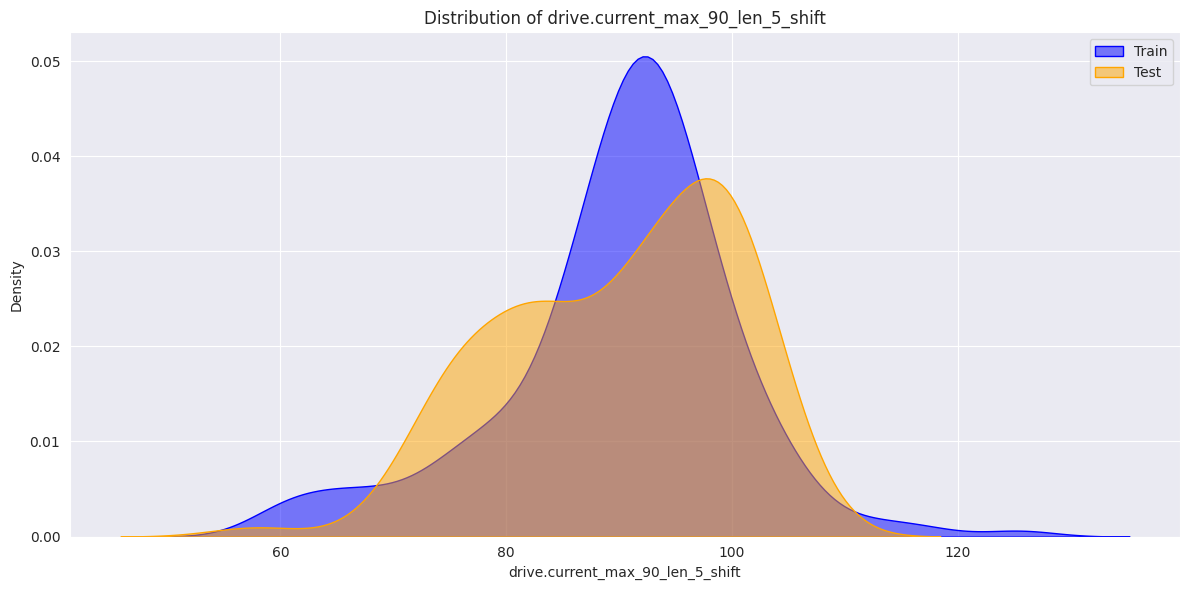

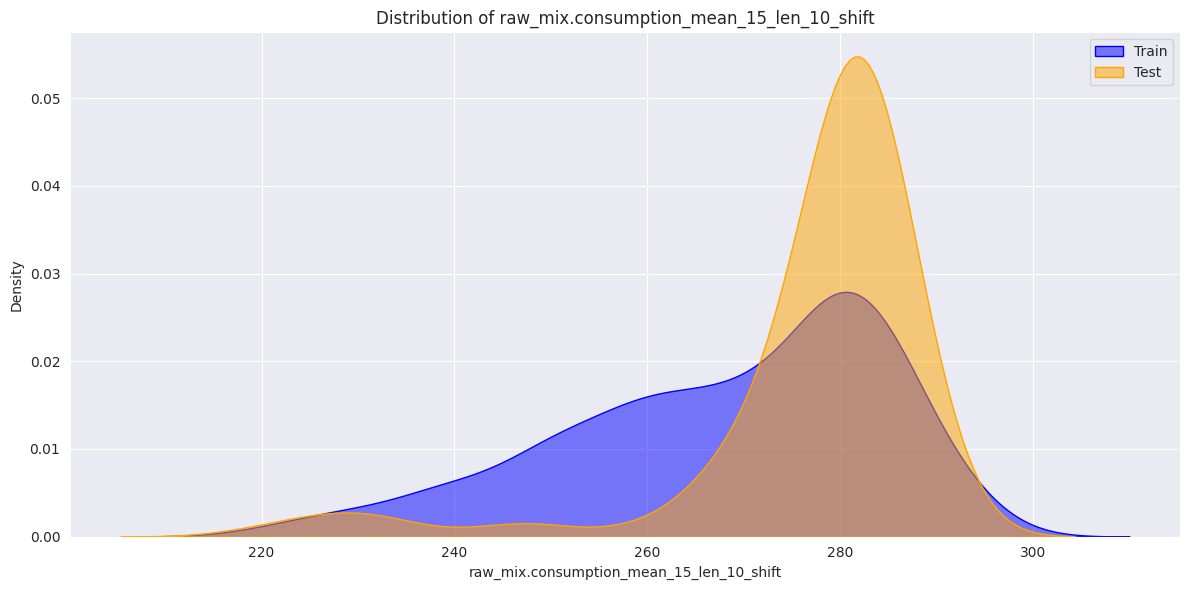

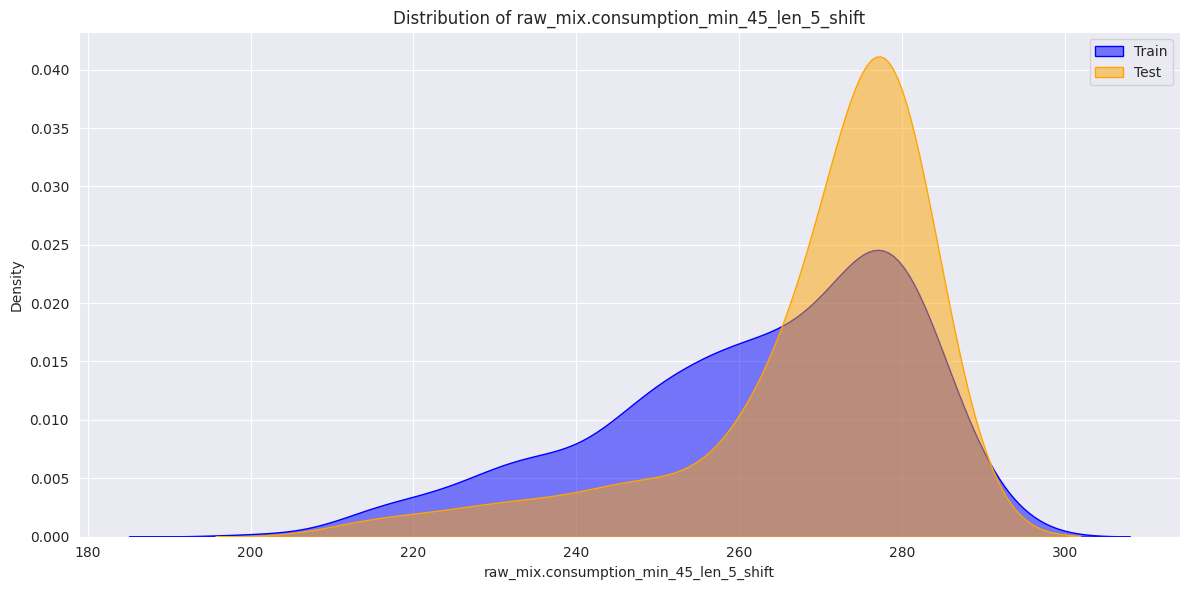

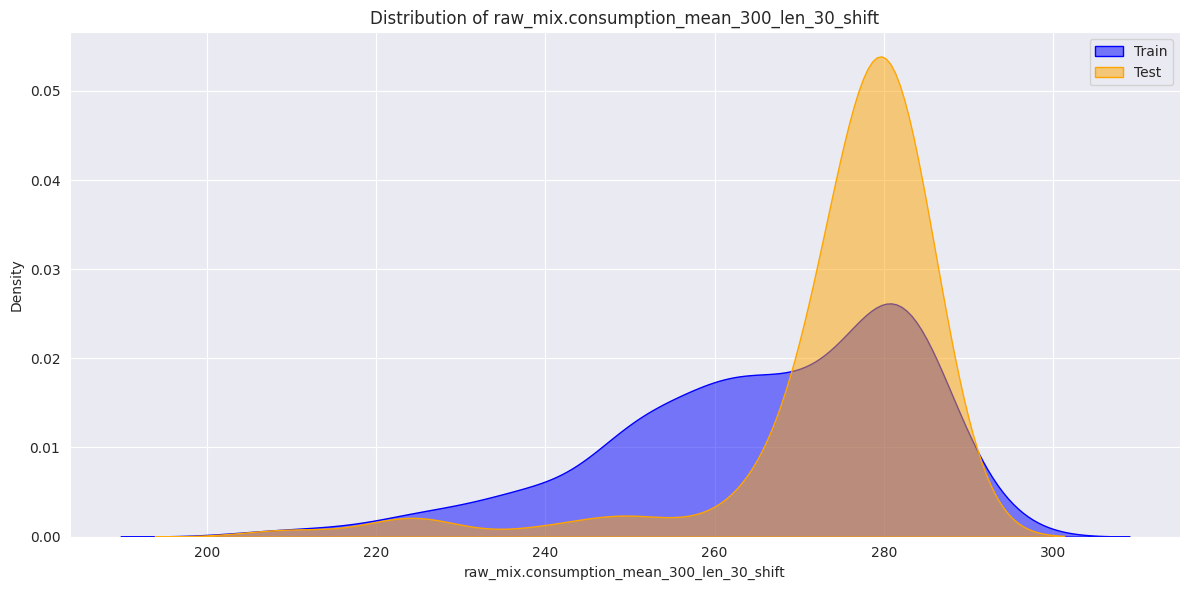

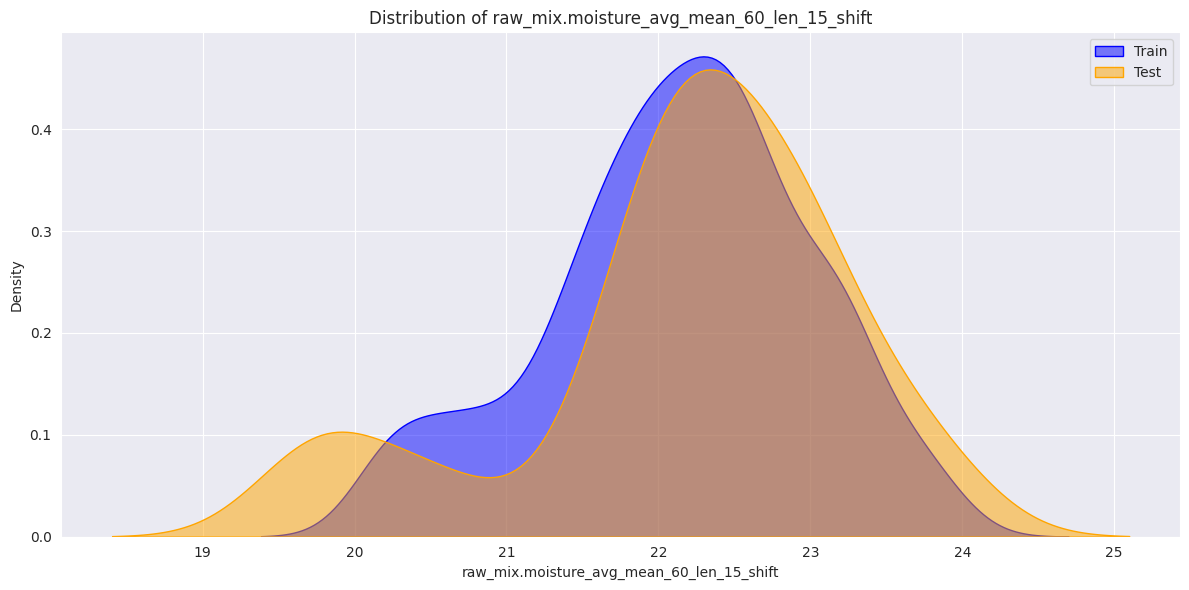

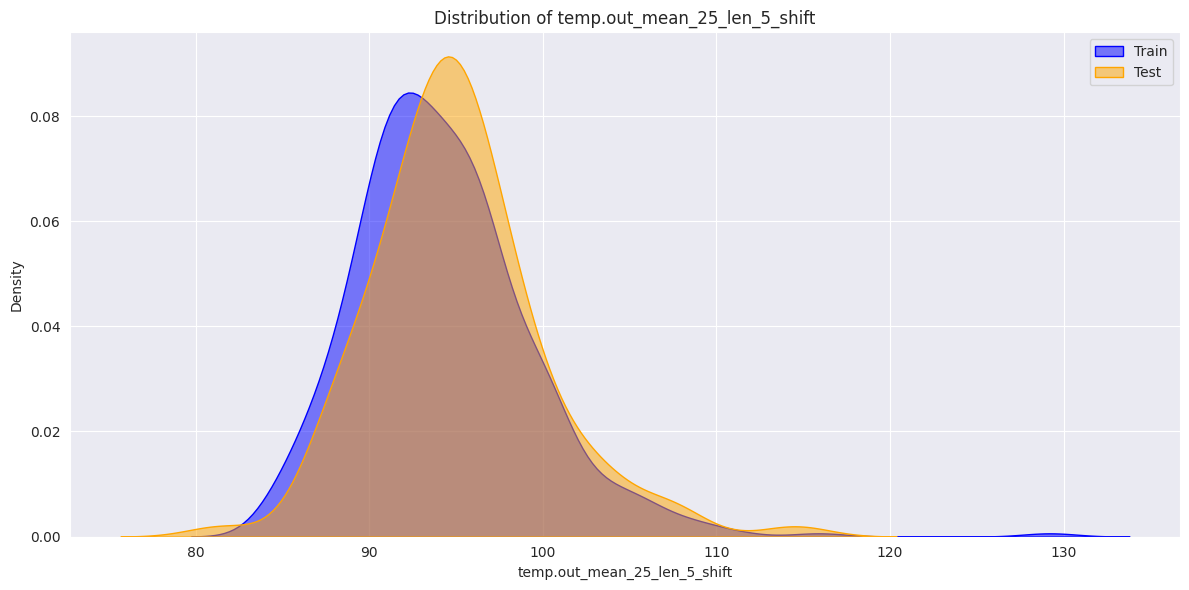

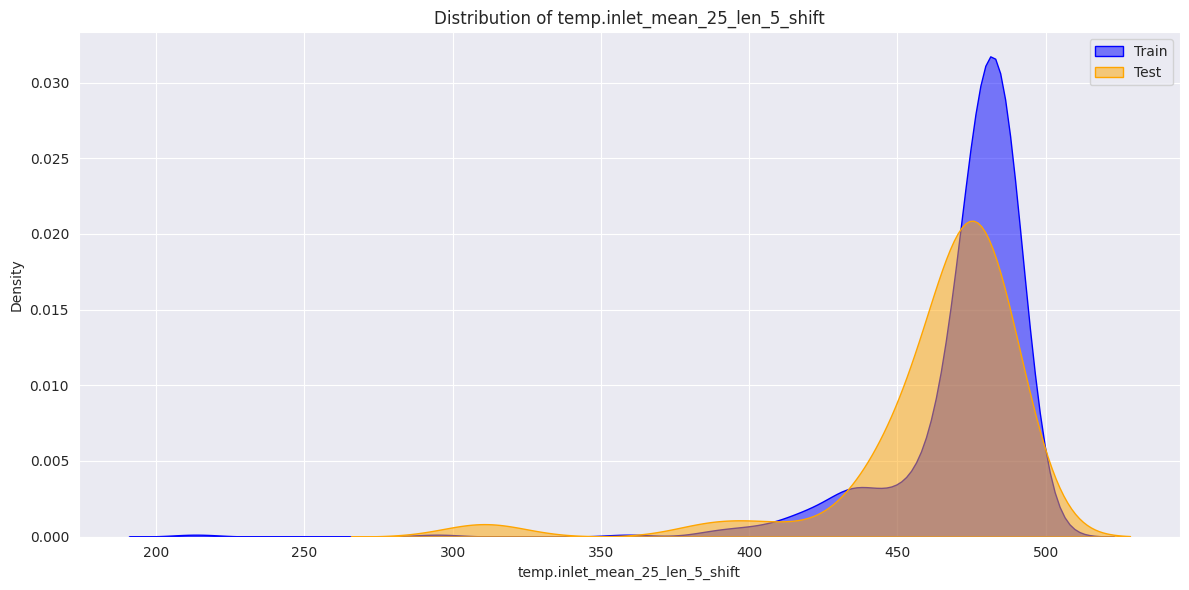

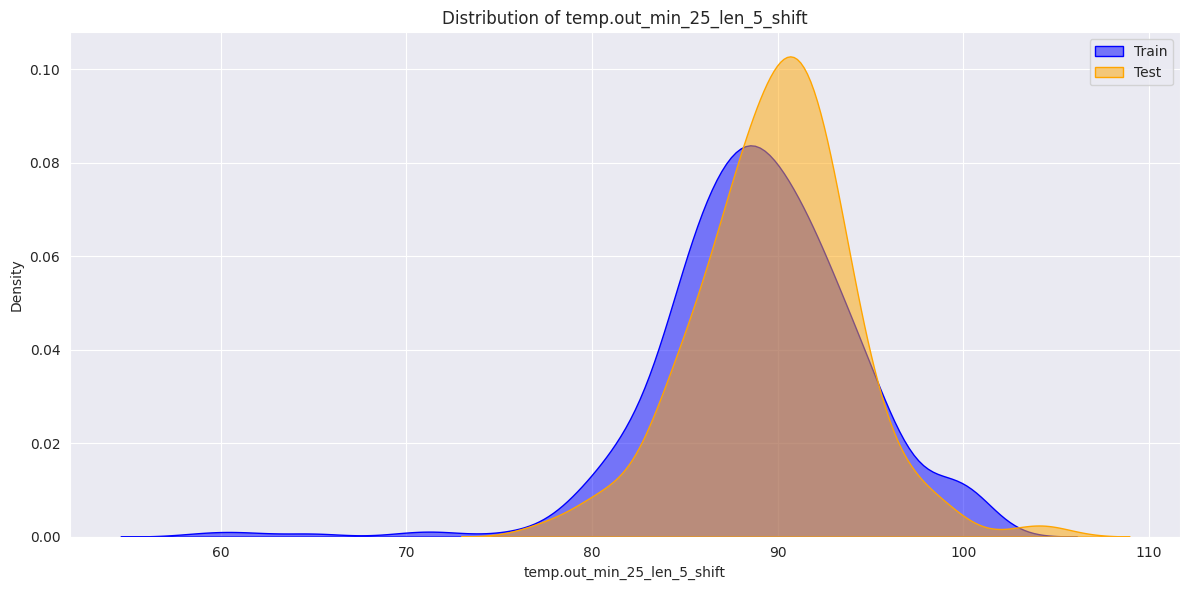

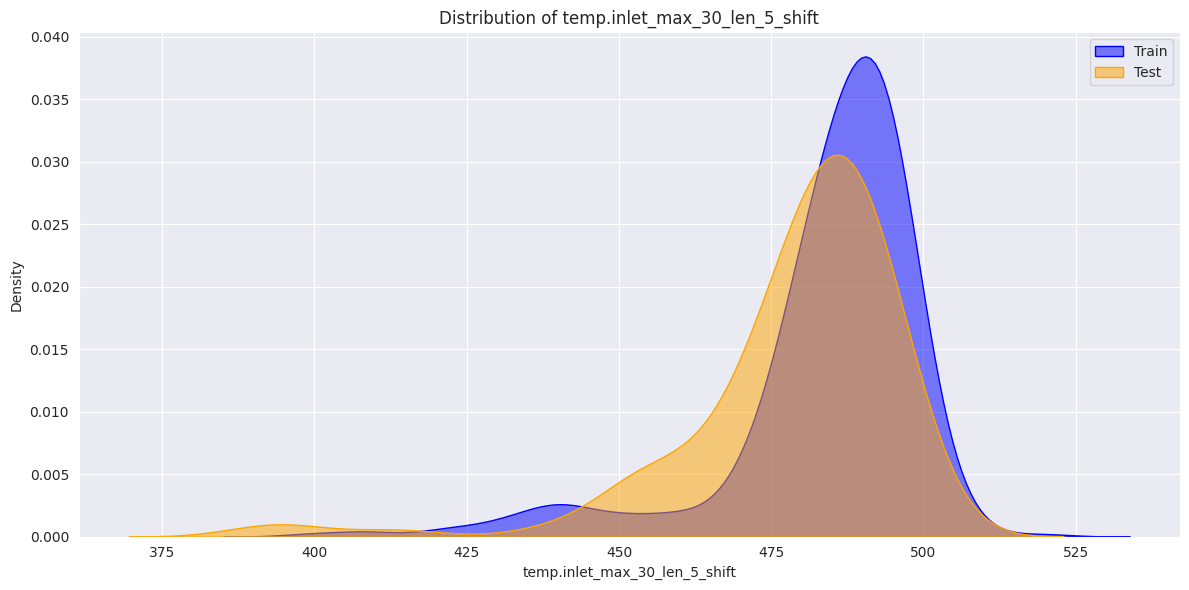

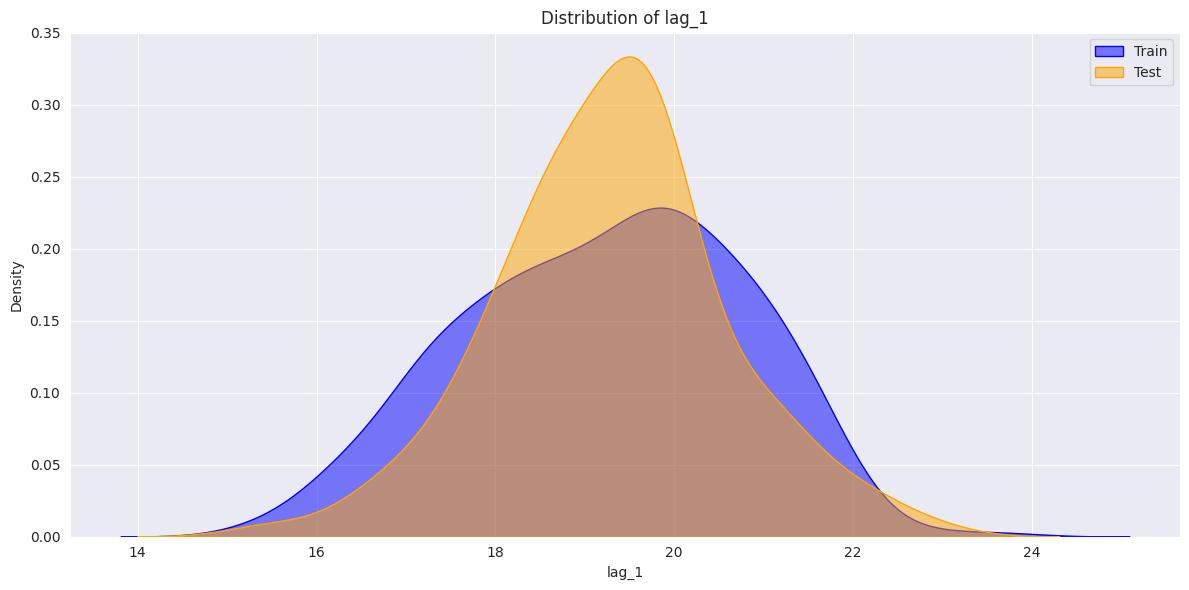

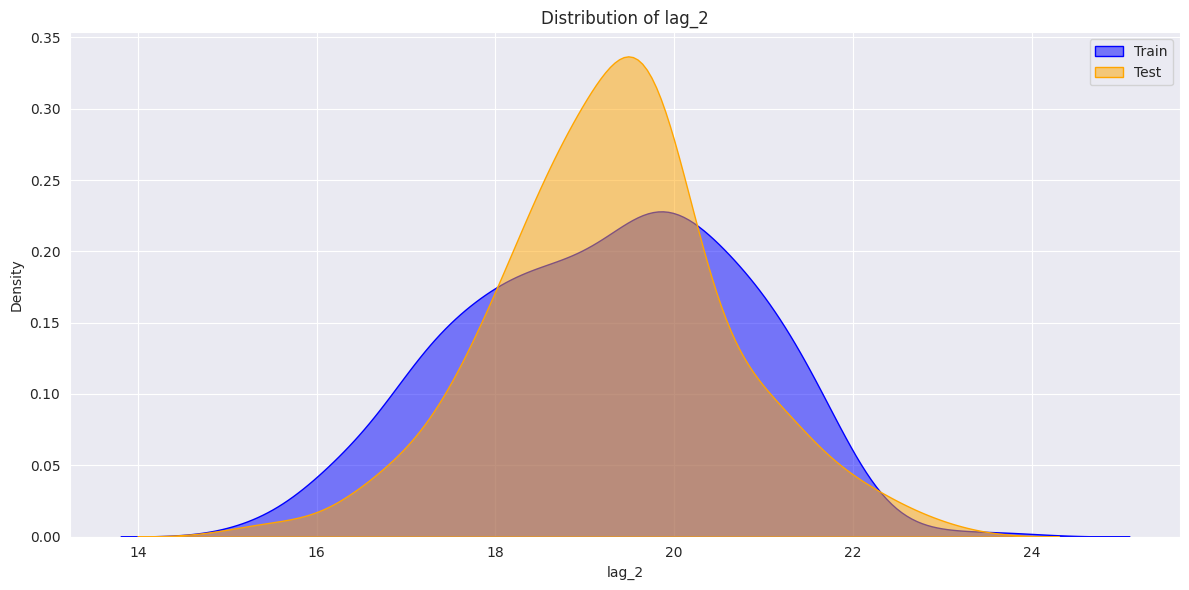

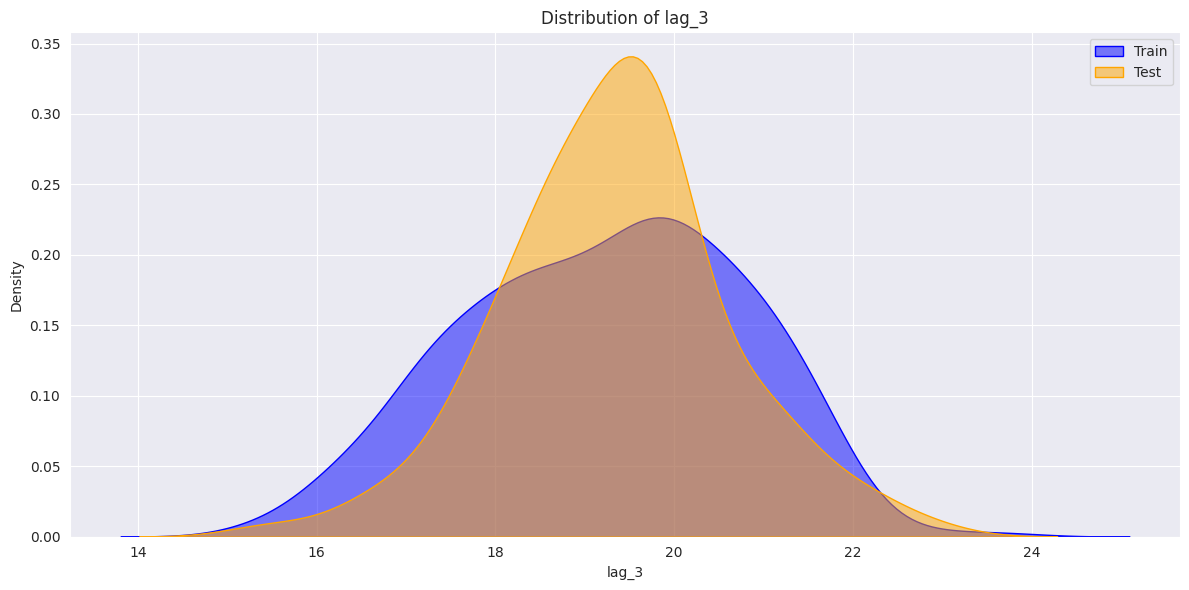

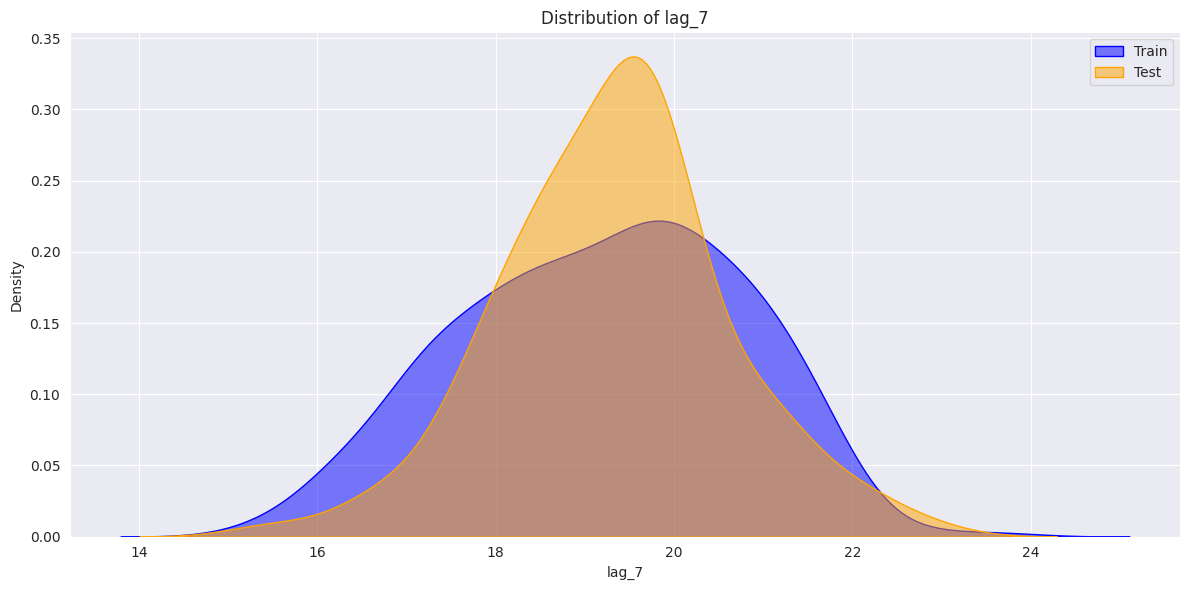

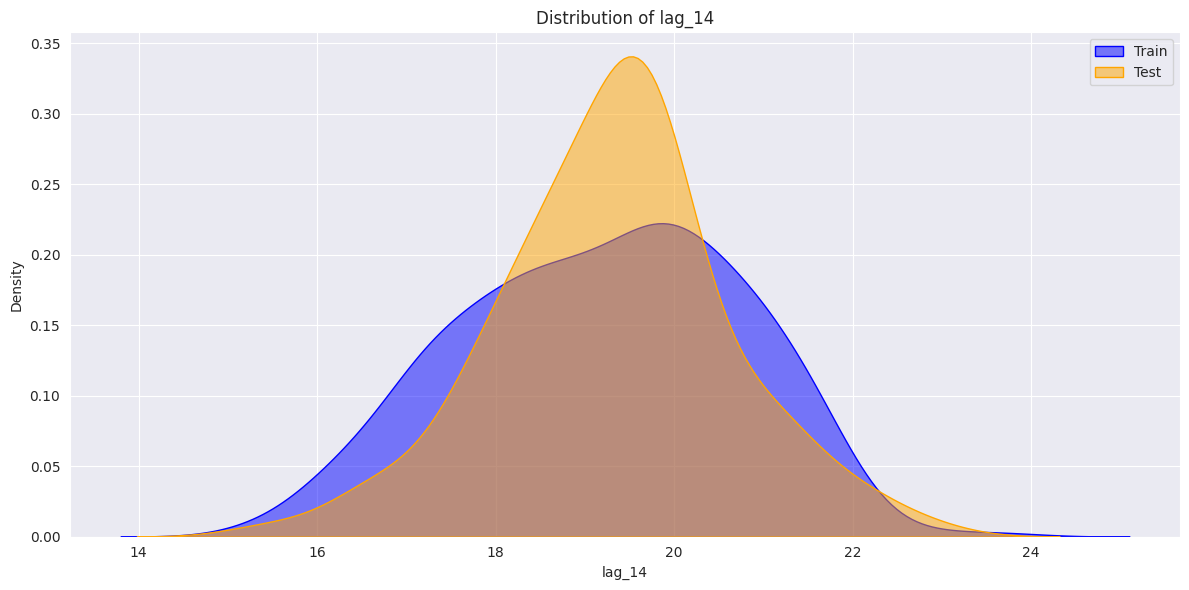

In [14]:
# Визуализация распределения признаков и целевой переменной
for feature in features:
    plt.figure(figsize=(12, 6))
    sns.kdeplot(data=X_train[feature], label='Train', color='blue', fill=True, alpha=0.5)
    sns.kdeplot(data=X_test[feature], label='Test', color='orange', fill=True, alpha=0.5)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Density')
    plt.legend()
    plt.tight_layout()
    plt.show()

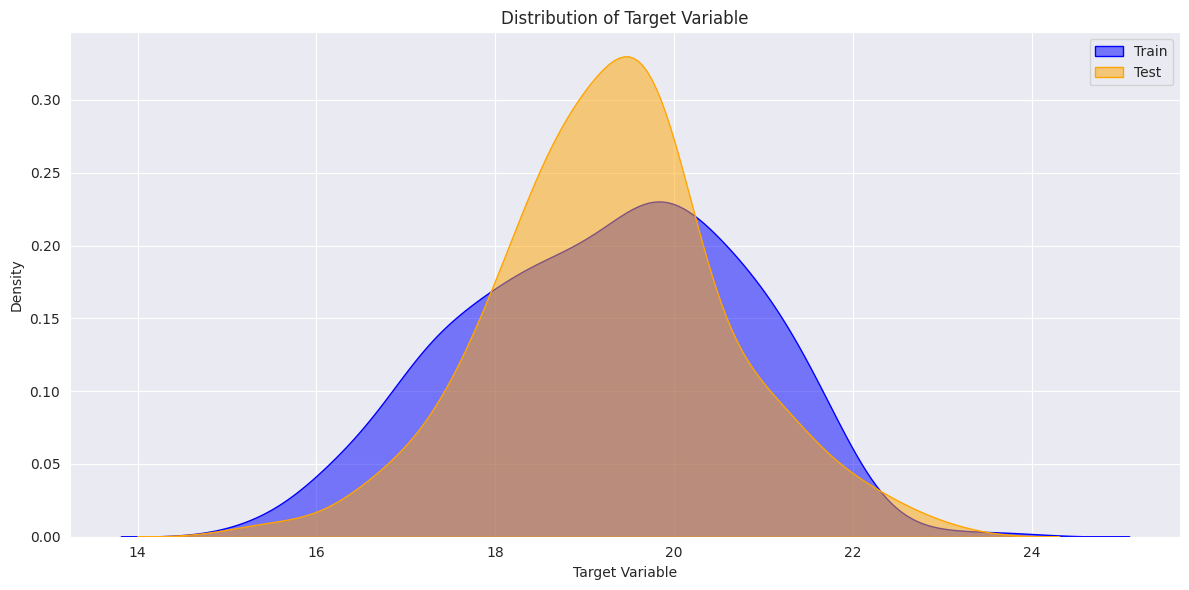

In [15]:
# График распределения целевой переменной
plt.figure(figsize=(12, 6))
sns.kdeplot(data=y_train, label='Train', color='blue', fill=True, alpha=0.5)
sns.kdeplot(data=y_test, label='Test', color='orange', fill=True, alpha=0.5)
plt.title('Distribution of Target Variable')
plt.xlabel('Target Variable')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.show()